## Notes


* Drop images with range 0-255

* reshape the images into 4\*32\*32 tile size, stride = 8, 

* Outpuy the images into training dataset folder

In [1]:
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader
import pandas as pd
from matplotlib import pyplot as plt
import os
from osgeo import gdal
import math
from tqdm import tqdm
import time
import rasterio as rio
import rasterio.plot as rioplt

/opt/conda/envs/mlenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read data and set the normalization parameters (fixed) PS
MS_list = glob.glob("/home/zbc123a/PS_Mesa_AnalyticMS_SR/"+"*clipped*.tif")
MS_list.sort()

max = [15428, 25493, 51991, 62883]
min = [0, 0, 0, 0]

In [10]:
# read data and set the normalization parameters (fixed) S2
prefire = "/home/zbc123a/Sentinel_Mesa_4Bands_clipped/S2B_20180726.tif"

postfire = "/home/zbc123a/Sentinel_Mesa_4Bands_clipped/S2B_20180815.tif"

max = [18408, 18855, 23857, 22105]
min = [0, 0, 0, 0]

In [3]:
band_dict = {1: "Band 1 - Blue", 2: "Band 2 - Green", 3: "Band 3 - Red", 4: "Band 4 - NIR"}

In [5]:
def normalizaed_data(img):
    #min-max normalization of the image based on all images
    #four bands, for different min, max
    max = [15428, 25493, 51991, 62883]
    min = [0, 0, 0, 0]
    img_normalized=np.zeros(img.shape)
    for i in range(4):
        img_normalized[i,:,:]=(img[i,:,:]-min[i])/(max[i]-min[i])
    
    return img_normalized.astype(np.float64)


In [6]:
def recover_data(arr):
    #recover min-max normalized image
    max = [15428, 25493, 51991, 62883]
    min = [0, 0, 0, 0]
    img_recovered=np.zeros(arr.shape)
    for i in range(4):
        img_recovered[i,:,:]=arr[i,:,:]*(max[i]-min[i])+min[i]
    
    return img_recovered.astype(np.float64)

In [7]:
# S2
def load_image(img_src,normalization = True):
    '''
    args:
    img_src - directory to the target image

    return:
    data_mtrx - a dictionary of two data matrices for pre and post fire; each of them is in 3 dimensions (band,rows,cols)
    meta_data - metadata includes: transformation, projection, numerber of rows, number of columns, number of bands
    band_dict - band dictionary includes the information of each band
    '''
    
    s2_name = os.path.basename(img_src)[:-4]
    loc_name = 'Mesa'
    print("Loading image: %s - %s" %(loc_name,s2_name))
    
    ds = gdal.Open(img_src)
    ds_arr = ds.ReadAsArray().astype(np.float32)
    
    if normalization:
        ds_arr = normalizaed_data(ds_arr)
    
    print("Loading image is done!")
    return ds_arr,s2_name,loc_name

In [18]:
# PS
def load_image(img_src,normalization = True):
    '''
    args:
    img_src - directory to the target image

    return:
    data_mtrx - a dictionary of two data matrices for pre and post fire; each of them is in 3 dimensions (band,rows,cols)
    meta_data - metadata includes: transformation, projection, numerber of rows, number of columns, number of bands
    band_dict - band dictionary includes the information of each band
    '''
    
    ps_name = os.path.basename(img_src).split("_")[0]
    loc_name = os.path.basename(img_src).split("_")[1]
    
    print("Loading image: %s - %s" %(loc_name,ps_name))
    
    ds = gdal.Open(img_src)
    ds_arr = ds.ReadAsArray().astype(np.float32)
    
    if normalization:
        ds_arr = normalizaed_data(ds_arr)
    
    print("Loading image is done!")
    return ds_arr,ps_name,loc_name

In [8]:
def create_image_tile(img_src, out_dir, stride_size=32, tile_size = 32):
    '''
    args:
    img_src - a path to 3-dimensional data matrix read from a satellite image
    tile_size - the size of the tile in integer, the default size is 3*3
    stride_size - the size of the stride in integer, for the size of moving pixels for each tile
    output - True/False, whether output the data matrix, the default is False
    out_dir - output directory of the tiled image the default is None. If the ouput is True, the out_dir is required. Output data type should be acceptable for the numpy.save, npy is recommended.

    return:
    data_mtrx_tile - a data matrix of the image after tiling

    '''
    data_mtrx, ps_name, loc_name = load_image(img_src)

    bands, rows, cols = data_mtrx.shape
    
    print("Start tiling the image...")
 
    new_rows = math.floor(1+(rows-tile_size)/stride_size) #asking huiqi to check this one, need to be changed
    new_cols = math.floor(1+(cols-tile_size)/stride_size)
    
    print("The numbers of rows and columns after tiling are (%d, %d)"%(new_rows,new_cols))

    for i in range(new_rows):
        if i<10:
            str_new_rows = '000'+str(i)
        elif i<100:
            str_new_rows = '00'+str(i)
        elif i<1000:
            str_new_rows = '0'+str(i)
        else:
            str_new_rows = str(i)
        for j in range(new_cols):
            if j<10:
                str_new_cols = '000'+str(j)
            elif j<100:
                str_new_cols = '00'+str(j)
            elif j<1000:
                str_new_cols = '0'+str(j)
            else:
                str_new_cols = str(j)
            cropped_arr = data_mtrx[:,i*stride_size : (i*stride_size+tile_size), j*stride_size : (j*stride_size+tile_size)]
            #cropped_arr[cropped_arr==0.0]=np.nan
            if np.isnan(cropped_arr).sum() == 0:
                output_file = os.path.join(out_dir,loc_name+"_"+ps_name+"_"+str_new_rows+"_"+str_new_cols+".npy")
                np.save(output_file, cropped_arr)
            if i == 0 and j==0:
                print("After tiling, the size of data matrix becomes: ", cropped_arr.shape)
    del data_mtrx, cropped_arr

In [11]:
create_image_tile(prefire, stride_size = 8, out_dir = "/home/zbc123a/S2_Downstream/Mesa_prefire") #stride 8

Loading image: Mesa - S2B_20180726
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (249, 196)
After tiling, the size of data matrix becomes:  (4, 32, 32)


In [12]:
create_image_tile(postfire, stride_size = 8,out_dir="/home/zbc123a/S2_Downstream/Mesa_postfire")

Loading image: Mesa - S2B_20180815
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (249, 196)
After tiling, the size of data matrix becomes:  (4, 32, 32)


In [41]:
test = np.load("/home/zbc123a/PS_Downstream/Mesa_SR_postfire/AnalyticMS_PS_0100_0100.npy")

In [42]:
test_original = recover_data(test)/2000

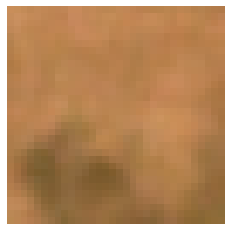

In [43]:
plt.figure()
plt.imshow(np.moveaxis(test_original[[2,1,0],:,:],0,-1))
plt.axis("off")
plt.show()